In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.optimize import nnls
from sklearn.decomposition import FastICA
%matplotlib inline
from utils import *

```python
wave_list = [750, 760, 800, 850, 900, 910, 920, 930, 940, 950]
wave_list = sorted([int(wave[:3]) for wave in os.listdir('/20230305_Cholesterol_3/Phantom 2/')])
wave_list = sorted([int(wave[:3]) for wave in os.listdir('../expdata/20230217 Cholesterol and Blood Mix/') if wave[-3:] == 'mat'])
```

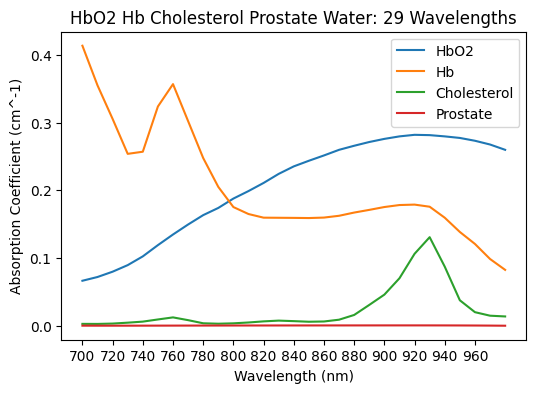

In [2]:
wave_list = np.arange(700, 981, 10)
abs_coeff, legend = {}, ["HbO2", "Hb", "Cholesterol", "Prostate", "Water"]
wave_abs = np.load('./data/hbo2hbchpr_57.npy')

for idx, wave in enumerate(np.arange(700, 981, 5)):
    abs_coeff[wave] = (idx, wave_abs[idx])
coeffs = np.vstack([abs_coeff[wave][1] for wave in wave_list])
weights_plot(array = coeffs[:, 0:], wave_list = wave_list, legend = legend)

Linear Unmixing 29 Wavelengths: Step Size of 10 nm

In [3]:
f = loadmat("./plot3d/plot3d-sim.mat")
X, Y = f['x'], f['y']

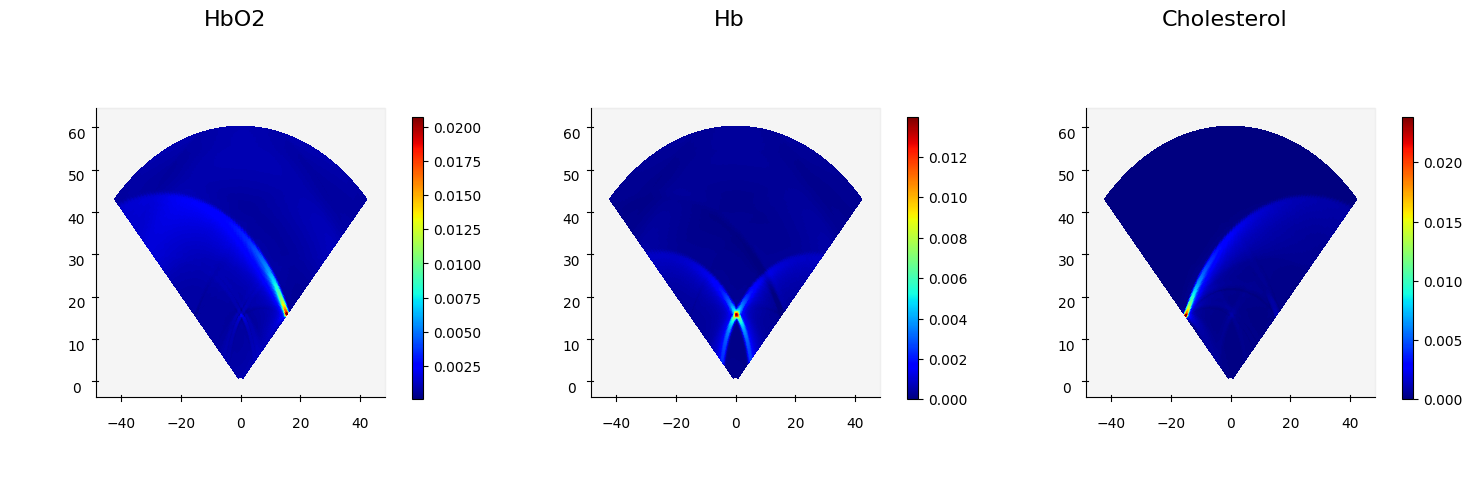

In [4]:
depth = 15
hbhbo2fat = np.copy(coeffs)[:, 0:3]
sim_data = np.array([np.array(loadmat(f"./data/hb_hbo2_fat_29_{depth}/PA_Image_{wave}.mat")['Image_PA']) for wave in wave_list])
unmixed = run_linear_unmixing(sim_data, hbhbo2fat)
plot_3d_multiple(Y*1000, X*1000, unmixed, title = legend[:3], cmap = 'jet', clim = None, order = [0, 1, 2])

57 Wavelengths: Step Size of 5 nm

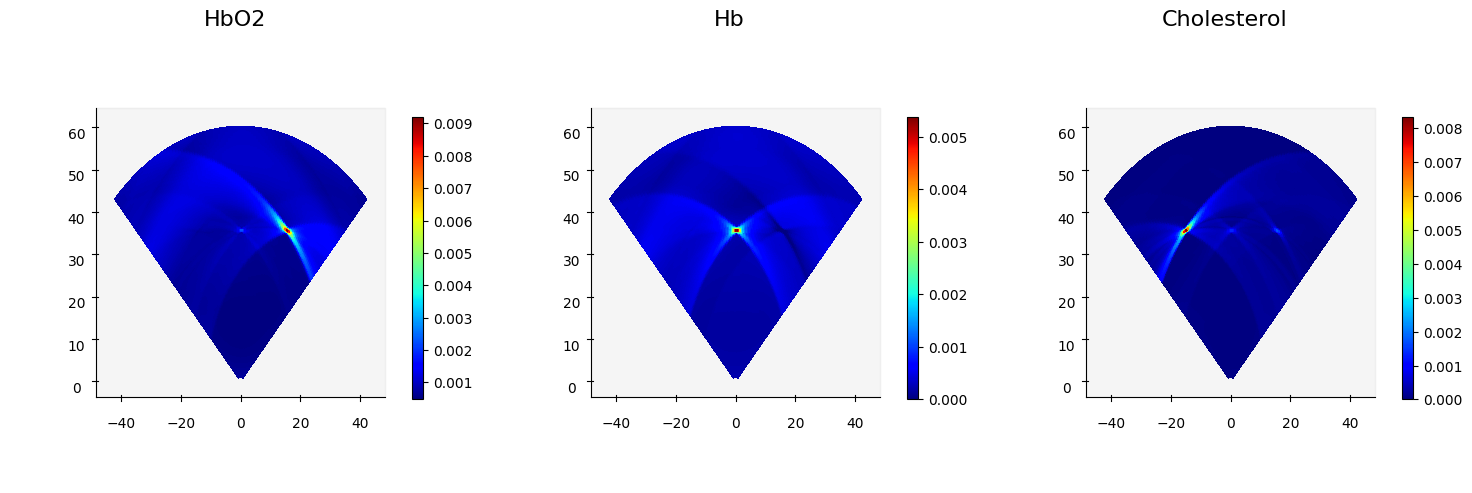

In [6]:
hbhbo2fat = np.copy(coeffs)[:, 0:3]
sim_data = np.array([np.array(loadmat(f"./data/hb_hbo2_fat_57/PA_Image_{wave}.mat")['Image_PA']) for wave in wave_list])
unmixed = run_linear_unmixing(sim_data, hbhbo2fat)
plot_3d_multiple(Y*1000, X*1000, unmixed, title = legend[:3], cmap = 'jet', clim = None, order = [0, 1, 2])

ICA

In [ ]:
for i in range(20):
    print(f"Random State: {i}")
    maps, wts, _ = run_ica(sim_data, wave_list, 3, i)
    plot_ica_2d(maps, wave_list, wts, figsize = (10, 3))

In [ ]:
maps, wts, model = run_ica(sim_data, wave_list, 3, 15)
plot_3d_multiple(Y*1000, X*1000, maps, title = legend[:3], cmap = 'jet', clim = None, order = [0, 2, 1])

Testing on the Trained ICA Model

In [ ]:
depth = 40
hbhbo2fat = np.copy(coeffs)[:, 0:3]
sim_data = np.array([np.array(loadmat(f"../data/hb_hbo2_fat_29_{depth}/PA_Image_{wave}.mat")['Image_PA']) for wave in wave_list])
test_data = sim_data.transpose((1, 2, 0)).reshape((-1, len(wave_list))).T
test_data_mean = test_data.mean(axis = -1)
test_data -= test_data_mean[:, np.newaxis]
test_comps = np.linalg.multi_dot([model._unmixing, model.whitening_, test_data]).T.reshape((396, 101, 3))
plot_3d_multiple(Y*1000, X*1000, test_comps, title = legend[:3], cmap = 'jet', clim = None, order = [0, 2, 1])

## Experimental Cholesterol

In [ ]:
fp = loadmat('../plot3d/plot3d-phantom.mat')
Xp, Yp = np.real(fp['x']), np.real(fp['y'])

20230305_Cholesterol_3 Cholesterol Phantoms

In [ ]:
expdata = np.array([np.mean(np.array(loadmat(f'/content/20230305_Cholesterol_3/Phantom 1/{wave}nm.mat')['ImgData'])[1][0], axis = 3)[:,:,0] for wave in wave_list])
wave, h, w = expdata.shape

20230217_Cholesterol_Blood Phantoms

In [ ]:
expdata = np.array([np.mean(np.array(loadmat(f'../expdata/20230217 Cholesterol and Blood Mix/{wave}nm.mat')['ImgData'])[1][0], axis = 3)[:,:,0] for wave in wave_list])
wave, h, w = expdata.shape

In [ ]:
linear_comps = run_linear_unmixing(expdata, hbhbo2fat)
plot_ica_2d(linear_comps, wave_list, hbhbo2fat, "Linear Unmixing", (15, 4))
# plot_3d_multiple(Yp*1000, Xp*1000, linear_comps, title = legend[:3], cmap = 'jet', clim = None, order = [0, 1, 2])

In [ ]:
test_data = expdata.reshape((wave, h*w))
test_data_mean = test_data.mean(axis = -1)
test_data -= test_data_mean[:, np.newaxis]
test_comps = np.linalg.multi_dot([model._unmixing, model.whitening_, test_data]).T.reshape((h, w, 3))
plot_ica_2d(test_comps, wave_list, model.components_.T)

In [ ]:
plt.figure(figsize = (15, 10))
for i, wave in enumerate(sorted([int(wave[:3]) for wave in os.listdir(f"/content/20230217_Cholesterol_Blood/") if wave[-3:] == 'mat'])):
    plt.subplot(3, 6, i+1)
    plt.imshow(np.mean(np.array(loadmat(f'/content/20230217_Cholesterol_Blood/{wave}nm.mat')['ImgData'])[1][0], axis = 3)[:,:,0], cmap = "hot")
    plt.title(f"{wave} nm")
    plt.colorbar()
plt.show()

## Animal Experiments

In [ ]:
f = loadmat("../expdata/All Animal Results to Date/CONTROL MICE/03.31 Exp 2 (10 WV)/ALL_FRAMES_MOTIONREMOVED.mat")

In [ ]:
exp_wave_list = [int(key[-3:]) for key in f.keys() if key[:3] == 'all']
plt.figure(figsize = (20, 8))
for i, wave in enumerate(exp_wave_list):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.mean(f[f'all{wave}'], axis = 2), cmap = "hot")
    plt.title(f"{wave} nm")
    plt.colorbar()
plt.show()